# Frequency based text models

Later in the course, we either use pre-trained models or models we trained ourselves for a corpus. Trained means, a statistical model is used for text analysis whose output depends on parameters that impact the model output. Before we use these more advanced techniques, we want to start with simpler approaches. Looking at our corpus, we want to aggregate the information in each document, usually by transforming it into a numerical representation. 

## Frequency based modeling

One of the easiest way to do this is to count the number of occurrences for every term in the document which ist listed in the lexicon. This approach is called bag-of-words which describes the fact we ignore the relationship of all words to each other and, hereby, loose semantic information. Let the number of documents be $n$ and the number of terms in the lexicon $d$, the corpus can be transformed to a document-term matrix $D$

$$
D = 
\begin{pmatrix}
x_{11} & x_{12} & \cdots & x_{1d} \\
\vdots & \vdots & \ddots & \vdots \\
x_{n1} & x_{n2} & \cdots & x_{nd} \\
\end{pmatrix}
$$

with $x_{ij}$ describing the number of term $j$ in document $i$. For larger corpora, $d$ is a large number so $D$ is a high-dimensional and, typically, sparse matrix which means the matrix has many zeros and only a few non-zero entries. A few options exist which can help dealing with this issue. One is the removal of stopwords. Other options are to exclude words with little and very high frequency or to exclude words with very little or high document occurrence. However, these measures need to be evaluated carefully, because sometimes words with little occurrence or frequency might provide more information than words with high occurrence of frequency. The bag-of-words approach can be conducted quite easily with the CountVectorizer class of the sklearn package. See a little demonstration in the following cells.

In [1]:
import sqlite3
import pandas as pd
from gensim.utils import simple_preprocess
from gensim.parsing.preprocessing import STOPWORDS
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.metrics.pairwise import euclidean_distances, cosine_distances, cosine_similarity
import pysentiment2 as ps
import numpy as np
import matplotlib.pylab as plt

In [2]:
# load Apple's 10-K filings
conn = sqlite3.connect("../data/dlta_texts.db")
sql_query = "SELECT * FROM filings;"
df_filings = pd.read_sql(sql_query, conn)
apple_filings = df_filings[df_filings.ticker == "AAPL"]
apple_filings = apple_filings.sort_values("filingDate")
apple_filings.reset_index(inplace=True, drop=True)
conn.close()
apple_filings.tail(2)

,accessionNumber,filingDate,reportDate,acceptanceDateTime,act,form,fileNumber,filmNumber,items,size,isXBRL,isInlineXBRL,primaryDocument,primaryDocDescription,ticker,cik,text
19,0000320193-21-000105,2021-10-29,2021-09-25,2021-10-28T18:04:28.000Z,34,10-K,001-36743,211359752,,10502096,1,1,aapl-20210925.htm,10-K,AAPL,0000320193,10-K\n 1\n aapl-20210925.htm\n 10-K\n \n \n \n...
20,0000320193-22-000108,2022-10-28,2022-09-24,2022-10-27T18:01:14.000Z,34,10-K,001-36743,221338448,,10332356,1,1,aapl-20220924.htm,10-K,AAPL,0000320193,10-K\n 1\n aapl-20220924.htm\n 10-K\n \n \n \n...


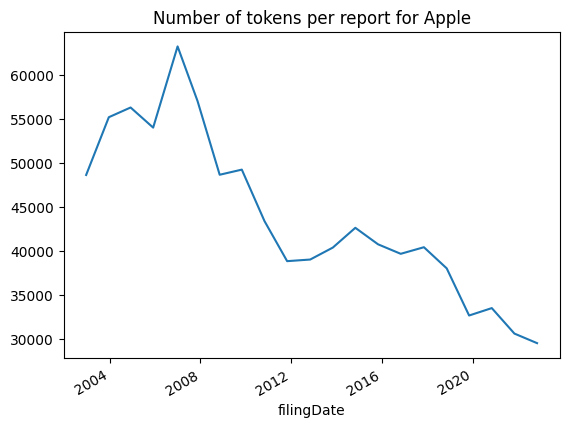

In [3]:
# a first check regarding the length of these reports
# import raw text
raw_reports = apple_filings.text.values
# preprocess each report
processed_reports = [simple_preprocess(report) for report in raw_reports]
# count the number of tokens for each report
nbr_words_per_report = [len(report) for report in processed_reports]
dates = pd.to_datetime(apple_filings.filingDate)
words_per_report = pd.Series(index = dates, data = nbr_words_per_report)

# visualize the number of tokens per Apple report over time
fig, ax = plt.subplots()
words_per_report.plot(title = "Number of tokens per report for Apple", ax = ax)
plt.show()

Using the CountVectorizer with its default settings:

In [4]:
# create the bag-of-words with default settings
vectorizer = CountVectorizer(preprocessor = lambda x: " ".join(simple_preprocess(x)))
# the output is a sparse matrix, the first dimension are the number of reports, the second dimension is the number of terms
X = vectorizer.fit_transform(raw_reports)
# let us take a look at the first reports
feature_names = vectorizer.get_feature_names_out()
bow_default = pd.DataFrame(X.toarray(), index = dates, columns = feature_names)
bow_default.tail()

,aac,aad,aapl,abandoned,abbett,abilities,ability,able,abnormal,abnormally,...,yo,york,yosemite,young,youtube,zayante,zero,zip,zones,zoom
filingDate,,,,,,,,,,,,,,,,,,,,,
2018-11-05,0,0,1,0,0,1,23,9,0,0,...,0,9,0,3,0,0,0,1,0,1
2019-10-31,0,0,116,0,0,1,19,9,0,0,...,0,2,0,3,0,0,0,1,0,0
2020-10-30,0,0,152,0,0,1,22,9,0,0,...,0,2,0,3,0,0,0,1,0,0
2021-10-29,0,0,130,0,0,1,26,10,0,0,...,0,2,0,3,0,0,0,1,0,0
2022-10-28,0,0,109,0,0,1,27,9,0,0,...,0,3,0,4,0,0,0,1,0,0


Using the CountVectorizer and deleting stopwords:

In [5]:
# import the stopword list from the gensim package
stopword_list = list(STOPWORDS)
stopword_list.sort()

# create the bag-of-words
vectorizer = CountVectorizer(preprocessor = lambda x: " ".join(simple_preprocess(x)), stop_words = stopword_list)
X = vectorizer.fit_transform(raw_reports)
# let us take a look at the first reports
feature_names = vectorizer.get_feature_names_out()
bow_wo_stopwords = pd.DataFrame(X.toarray(), index = dates, columns = feature_names)
bow_wo_stopwords.tail()

,aac,aad,aapl,abandoned,abbett,abilities,ability,able,abnormal,abnormally,...,yo,york,yosemite,young,youtube,zayante,zero,zip,zones,zoom
filingDate,,,,,,,,,,,,,,,,,,,,,
2018-11-05,0,0,1,0,0,1,23,9,0,0,...,0,9,0,3,0,0,0,1,0,1
2019-10-31,0,0,116,0,0,1,19,9,0,0,...,0,2,0,3,0,0,0,1,0,0
2020-10-30,0,0,152,0,0,1,22,9,0,0,...,0,2,0,3,0,0,0,1,0,0
2021-10-29,0,0,130,0,0,1,26,10,0,0,...,0,2,0,3,0,0,0,1,0,0
2022-10-28,0,0,109,0,0,1,27,9,0,0,...,0,3,0,4,0,0,0,1,0,0


Using the CountVectorizer and restrict the counting to the top 100 features ordered by frequency across the corpus.

In [6]:
# create the bag-of-words
vectorizer = CountVectorizer(preprocessor = lambda x: " ".join(simple_preprocess(x)), stop_words = stopword_list, max_features = 100)
X = vectorizer.fit_transform(raw_reports)
# let us take a look at the first reports
feature_names = vectorizer.get_feature_names_out()
bow_top100 = pd.DataFrame(X.toarray(), index = dates, columns = feature_names)
bow_top100.tail()

,accounting,adversely,apple,assets,available,based,billion,business,cash,certain,...,subject,table,tax,taxes,term,time,total,value,year,years
filingDate,,,,,,,,,,,,,,,,,,,,,
2018-11-05,64,52,190,89,45,88,133,66,115,91,...,58,27,179,50,48,48,90,90,47,46
2019-10-31,57,37,132,80,39,70,114,56,128,81,...,53,20,128,41,46,29,91,92,41,48
2020-10-30,54,51,138,84,38,71,123,72,122,85,...,58,22,122,37,45,34,92,89,31,45
2021-10-29,43,59,127,63,30,66,86,104,69,75,...,62,14,113,35,34,45,76,64,31,44
2022-10-28,44,64,136,65,24,66,82,106,67,69,...,60,12,101,36,33,49,75,66,37,42


Another option which sometimes makes sense is to transform the occurrence of words in a document only in a binary fashion, i.e., $1$ if the word occurs and $0$ otherwise.

In [7]:
# create the bag-of-words
vectorizer = CountVectorizer(preprocessor = lambda x: " ".join(simple_preprocess(x)), stop_words = stopword_list, binary = True)
X = vectorizer.fit_transform(raw_reports)
# let us take a look at the first reports
feature_names = vectorizer.get_feature_names_out()
bow_binary = pd.DataFrame(X.toarray(), index = dates, columns = feature_names)
bow_binary.tail()

,aac,aad,aapl,abandoned,abbett,abilities,ability,able,abnormal,abnormally,...,yo,york,yosemite,young,youtube,zayante,zero,zip,zones,zoom
filingDate,,,,,,,,,,,,,,,,,,,,,
2018-11-05,0,0,1,0,0,1,1,1,0,0,...,0,1,0,1,0,0,0,1,0,1
2019-10-31,0,0,1,0,0,1,1,1,0,0,...,0,1,0,1,0,0,0,1,0,0
2020-10-30,0,0,1,0,0,1,1,1,0,0,...,0,1,0,1,0,0,0,1,0,0
2021-10-29,0,0,1,0,0,1,1,1,0,0,...,0,1,0,1,0,0,0,1,0,0
2022-10-28,0,0,1,0,0,1,1,1,0,0,...,0,1,0,1,0,0,0,1,0,0


Note that it is also possible to include multi-grams of words. For instance if we also consider two adjacent word as a term, this is called a bigram. This exponentially increases the number of terms, however, if we only consider bigrams with a certain minimum occurrence, we may capture special word combinations such as "New York".

Words which appear often in all documents are not very informative. Besides the removal of high frequency words, this can be either handled by frequency normalization. One of the most common term frequency normalization is term-frequency inverse-document-frequency (tf-idf). First, we count the number of documents in which the term occurs $n_j$ and set it in relation to the overall number of documents $n$. We use this to calcluate $id_j = \log \left( \frac{n}{n_j} \right)$ which is non-negative and higher the less often terms appear in different documents. To determine the tf-idf, term frequencies are determined per document $tf_{ij}$ and weighted with $id_j$:

$$
tf-idf =  tf_{ij} \cdot id_j
$$

The usage of tf-idf is not always of advantage and it needs to be tested if normalization leads to better results. See below for an example how to generate tf-idf representations using the TfidfVectorizer class.

In [8]:
# create the tf-idf representation
vectorizer = TfidfVectorizer(preprocessor = lambda x: " ".join(simple_preprocess(x)), stop_words = stopword_list)
X = vectorizer.fit_transform(raw_reports)
# let us take a look at the first reports
feature_names = vectorizer.get_feature_names_out()
tfidf_wo_stopwords = pd.DataFrame(X.toarray(), index = dates, columns = feature_names)
tfidf_wo_stopwords.tail()

,aac,aad,aapl,abandoned,abbett,abilities,ability,able,abnormal,abnormally,...,yo,york,yosemite,young,youtube,zayante,zero,zip,zones,zoom
filingDate,,,,,,,,,,,,,,,,,,,,,
2018-11-05,0.0,0.0,0.000694,0.0,0.0,0.000694,0.015961,0.006246,0.0,0.0,...,0.0,0.006841,0.0,0.002500,0.0,0.0,0.0,0.000694,0.0,0.001596
2019-10-31,0.0,0.0,0.088962,0.0,0.0,0.000767,0.014571,0.006902,0.0,0.0,...,0.0,0.001680,0.0,0.002762,0.0,0.0,0.0,0.000767,0.0,0.000000
2020-10-30,0.0,0.0,0.113777,0.0,0.0,0.000749,0.016468,0.006737,0.0,0.0,...,0.0,0.001640,0.0,0.002696,0.0,0.0,0.0,0.000749,0.0,0.000000
2021-10-29,0.0,0.0,0.106513,0.0,0.0,0.000819,0.021303,0.008193,0.0,0.0,...,0.0,0.001795,0.0,0.002951,0.0,0.0,0.0,0.000819,0.0,0.000000
2022-10-28,0.0,0.0,0.092510,0.0,0.0,0.000849,0.022915,0.007638,0.0,0.0,...,0.0,0.002789,0.0,0.004076,0.0,0.0,0.0,0.000849,0.0,0.000000


## Dictionary based modeling

In the examples above, we observe that each document is represented by a high dimensional vector. High dimensions can often be troublesome for machine learning methods. To deal with this issue, one may focus on the occurrences of certain words that fall into a category of interest. Usually, the common categories which are used are the number of positive and negative words. Which words are considered as negative and positive are defined by different dictionaries. An example for a general-purpose dictionary is the Harvard IV-4 dictionary. However, especially for financial documents general-purpose dictionaries may not be useful due to the domain specific usage of words, e.g., the word bear stands for bad market conditions or bull stands for good market conditions, respectively. [Loughran and McDonald (2011)](https://www.uts.edu.au/sites/default/files/ADG_Cons2015_Loughran%20McDonald%20JE%202011.pdf) find that the majority of general-purpose negative words from the Harvard dictionary found in in 10-K filings are not considered as negative in a financial context. This is why they generate their own dictionary. See the next cell's output for a few examples. Besides the categories positive and negative, they also generate the categories: uncertainty, litigious, strong modal, weak modal and constraining. Each report can be summarized by counting the (relative) frequencies of words falling into these categories. 


In [9]:
import json
import numpy as np

with open("../data/LMcD_word_list.json", "r") as file:
    lmcd_dict = json.load(file)

def dict_word_vectorizer(sentiment_dictionary, document, raw_counts = False, normalize = False):
    categories = list(sentiment_dictionary.keys())
    counts = []
    for category in categories:
        counts.append(len([word for word in document if word in sentiment_dictionary[category]]))
    if normalize:
        counts = [value  / len(document) for value in counts]
    if raw_counts:
        return counts
    else:
        return pd.DataFrame(data = [counts], columns = categories)


for key in lmcd_dict.keys():
    print(f"Examples for the category: {key}")
    print("-"*50)
    print(np.random.choice(lmcd_dict[key], 10, replace = False))
    print("-"*50)

Examples for the category: negative
--------------------------------------------------
['undercapitalized' 'drastic' 'unreasonableness' 'unavailable'
 'litigation' 'dissolutions' 'breakage' 'embargoing' 'strains'
 'unresolved']
--------------------------------------------------
Examples for the category: positive
--------------------------------------------------
['enabling' 'stabilize' 'perfectly' 'prestige' 'exceptional' 'achievement'
 'prosperous' 'constructively' 'highest' 'happiness']
--------------------------------------------------
Examples for the category: uncertainty
--------------------------------------------------
['believes' 'undefined' 'unknowns' 'undocumented' 'anomalous' 'differs'
 'unwritten' 'probability' 'conditional' 'speculating']
--------------------------------------------------
Examples for the category: litigious
--------------------------------------------------
['whomever' 'courtroom' 'facto' 'prejudices' 'acquittal' 'bonafide'
 'rebuttable' 'prosecution' '

Overall we see below that the dictionary mostly contains negative words. This may have different reasons, for instance, 10-K filings are reports in which companies are supposed to report about potential issues with respect to their business. Furthermore, the tone of financial reports traditionally has been quantified by the occurrences of negative words in documents. 

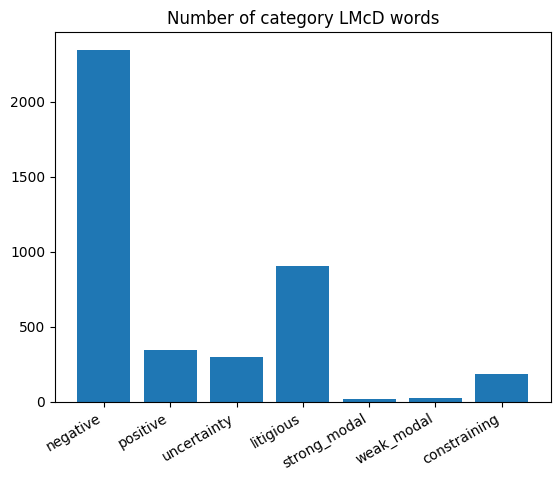

In [10]:
import matplotlib.pylab as plt 

fig, ax = plt.subplots()
labels = list(lmcd_dict.keys())
values = [len(lmcd_dict[word]) for word in labels]
ax.bar(x = labels, height = values)
ax.set_xticks(labels)
ax.set_xticklabels(labels, rotation = 30, ha = "right")
ax.set_title("Number of category LMcD words")
plt.show()

Below you can examine the development of word category frequencies for Apple 's 10-K filings. We can observe how the number of negative and litigious words rise during the great financial crisis. 

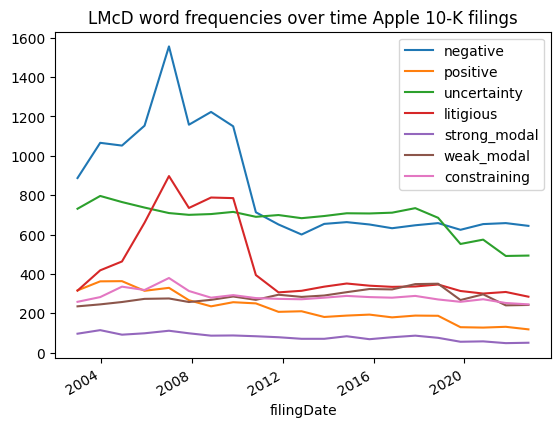

In [11]:
for i, report in enumerate(apple_filings.text):
    processed_report = simple_preprocess(report)
    if i == 0:
        lmcd_frequencies = dict_word_vectorizer(lmcd_dict, processed_report, raw_counts=False, normalize=False)
    else:
        lmcd_frequencies = pd.concat((lmcd_frequencies, dict_word_vectorizer(lmcd_dict, processed_report, raw_counts=False, normalize=False)))

lmcd_words_over_time = pd.DataFrame(data = lmcd_frequencies.values, index = pd.to_datetime(apple_filings.filingDate), columns = lmcd_frequencies.columns)
lmcd_words_over_time.plot(title = "LMcD word frequencies over time Apple 10-K filings")
plt.show()

## Polarity

Sometimes the occurrence of positive and negative words is translated into polarity. Polarity is the number of positive words minus the number of negative words divided by the overall number of positive and negative words.

$$
polarity = \frac{n^{positive} - n^{negative}}{n^{positive} + n^{negative}}
$$

See below how drastically the polarity of Apple's 10-K filings is impacted by the choice of the dictionary defining positive and negative words. We observe how the polarity decreases during the great financial crisis when using the dictionary by Loughran and McDonald (2011). In comparison, polarity does not decrease when using the general purpose Harvard IV-4 dictionary. This already indicates that domain-specific language modeling may be important for financial documents. 

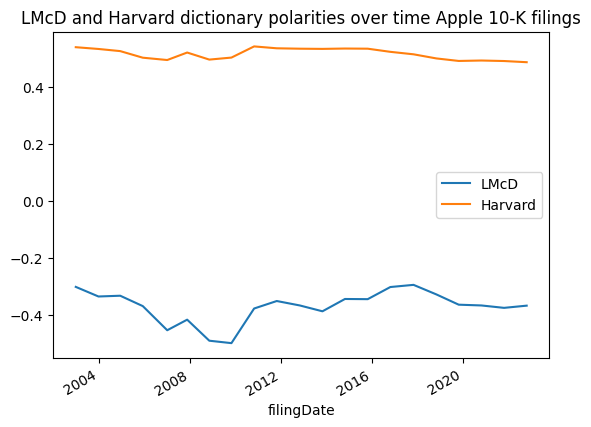

In [12]:
hv = ps.HIV4()
lm = ps.LM()

lm_polarity = []
hv_polarity = []

for report in apple_filings.text:
    lm_tokens = lm.tokenize(report)
    hv_tokens = hv.tokenize(report)
    lm_score = lm.get_score(lm_tokens)
    hv_score = hv.get_score(hv_tokens)
    lm_polarity.append(lm_score["Polarity"])
    hv_polarity.append(hv_score["Polarity"])

lmcd_harvard_polarity = pd.DataFrame([lm_polarity, hv_polarity], columns = pd.to_datetime(apple_filings.filingDate), index = ["LMcD", "Harvard"]).transpose()
lmcd_harvard_polarity.plot(title = "LMcD and Harvard dictionary polarities over time Apple 10-K filings")
plt.show()

## Similarity measures

Often, we want to quantify how similar document vectors are. This can be done by distance metrics of vectors. Popular choices are, e.g., the euclidean distance or cosine similarity. Given the document vectors $\boldsymbol{x}_i$ and $\boldsymbol{x}_k$, the euclidean distance is defined by:

$$
d_{euclidean}\left( \boldsymbol{x}_i, \boldsymbol{x}_k \right) = \sqrt{ \sum_{j=1}^{d} \left(x_{ij} - x_{kj} \right)^2} = ||\boldsymbol{x}_i - \boldsymbol{x}_k||
$$

The lower this value, the more close the document vectors are to each other, the more similar they should be. Cosine similarity is defined by:

$$
d_{cosine} (\boldsymbol{x}_i, \boldsymbol{x}_{k}) = \frac{\sum_{j = 1}^d  x_{ij} x_{kj}}{\sqrt{ \sum_{j = 1}^d x_{ij}^2} \sqrt{ \sum_{j = 1}^d x_{kj}^2}} = \frac{\boldsymbol{x}_i \cdot \boldsymbol{x}_k}{|| \boldsymbol{x}_i || || \boldsymbol{x}_k ||}
$$

It measures the angle between vectors and can have values in the range $[-1, 1]$. If each vector has only non-negative values, its range is in $[0, 1]$. The smaller the angle between the vectors, the higher the value for cosine similarity. 

Both measures can suffer in high-dimensional spaces, meaning if vectors have a high dimension. However, cosine similarity is often favored for text analysis, if it includes sparse vectors. Sparse vectors have many $0$ entries which have no impact on the distance measure (as the product in the numerator is always zero for this position). A [popular paper](https://onlinelibrary.wiley.com/doi/10.1111/jofi.12885) in the Journal of Finance by Cohen at al. (2020) finds that bigger changes in 10-K filings indicate a decline in the company's stock price. With this in mind, let us examine euclidean distances and cosine distances (1 - $d_{cosine}$) for the Apple filings.

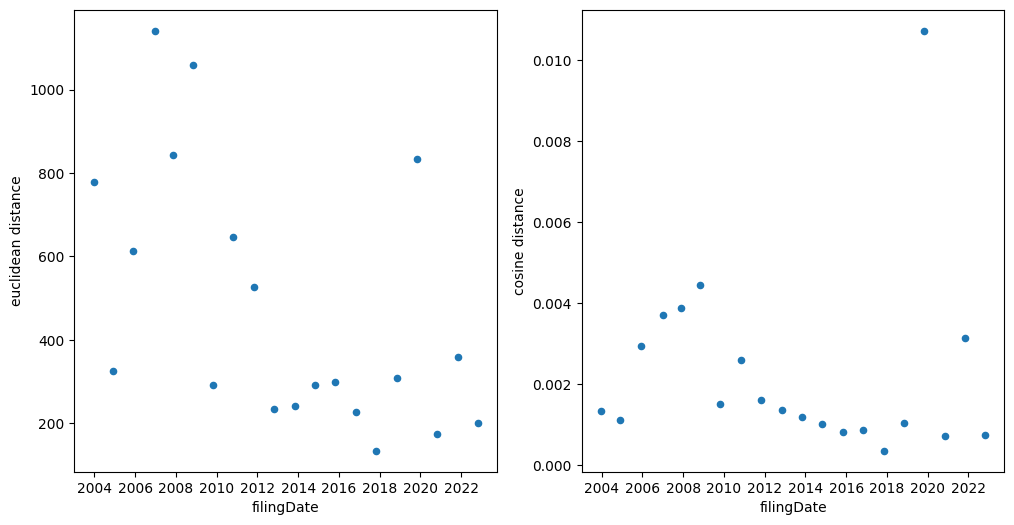

In [13]:
from sklearn.metrics.pairwise import cosine_distances, euclidean_distances
import numpy as np

# create the bag-of-words with default settings
vectorizer = CountVectorizer(preprocessor = lambda x: " ".join(simple_preprocess(x)))
# the output is a sparse matrix, the first dimension are the number of reports, the second dimension is the number of terms
X = vectorizer.fit_transform(raw_reports)

euc_distances = euclidean_distances(X)
cos_distances = cosine_distances(X)

distances_between_reports = apple_filings.get(["filingDate"]).copy()
distances_between_reports.loc[:, "euclidean distance"] =np.nan
distances_between_reports.loc[:, "cosine distance"] =np.nan
#cosine_distances_between_reports.loc[:, "cosine distance"] = cosine_distances_between_reports.loc[:, "cosine distance"].astype(float)
distances_between_reports.iloc[1:, 1] = np.diag(euc_distances, k = 1)
distances_between_reports.iloc[1:, 2] = np.diag(cos_distances, k = 1)
distances_between_reports.loc[:, "filingDate"] = pd.to_datetime(distances_between_reports.loc[:, "filingDate"])

fig, axs = plt.subplots(1, 2, figsize = (12, 6))
distances_between_reports.plot.scatter(x = "filingDate", y = "euclidean distance", ax = axs[0])
distances_between_reports.plot.scatter(x = "filingDate", y = "cosine distance", ax = axs[1])
plt.show()

## Chapter summary

This chapter shows how text can be transformed into a numerical representation by splitting each document into tokens and count their frequencies. We refer to this approach as the bag-of-words representation. In addition, this proceeding may be adjusted by giving frequencies weights which are inverse proportional to their document appearance over the corpus resulting in a term-frequency inverse-document-frequency or by ignoring most of the word and counting only the ones defined in a user-defined dictionary. No matter what we finally use, we start with a set of tokens for a document and end up with a vector. The dimension of the vector is driven by the size of the unique terms used for counting.

The numerical representation can be used as input for other algorithms, e.g., a clustering algorithm to build groups of similar documents or a supervised learning algorithm to predict outcomes for variables whose realizations may relate to the document's content (for instance sentiment prediction).

Another important concept is the similarity or dissimilarity between pairs of documents which can be quantified by appropriate metrics such as euclidean distance of cosine similarity or distance, respectively. 

To finalize this chapter, let us take a look at an example for an application in the financial domain which can be used to identify companies with more or little climate talk in their annual reports.

## Using word frequencies to identify climate talk in annual reports

This example is inspired by the paper by [Engle et al.](https://papers.ssrn.com/sol3/papers.cfm?abstract_id=3317570) who create a climate change news index to build a hedge portfolio against financial climate change risks. 

To capture climate risk for companies, they determine the cosine similarity between term-frequency inverse-document-frequencies from daily Wall Street Journal news and corresponding frequencies of a corpus which is explicitly dedicated to climate change (risks). Let us use this approach to reveal climate change talk in annual 10-K filings of stock market listed US companies. 

We start collecting climate white papers as provided in the Appendix A.2 in their paper. Next, we build a term-frequency inverse-document-frequency vectorizer which creates inverse-document frequencies for 10-K filings of 3,632 companies. Overall, the corpus consists of 30,840 10-K reports. The plots below exhibit the number of 10-K reports over time on a monthly and yearly level. We observe that most of the annual reports are filed in within the first quarter of a year as most of the company's fiscal year seems to end with the end of the year. This does not need to be the case for every company.

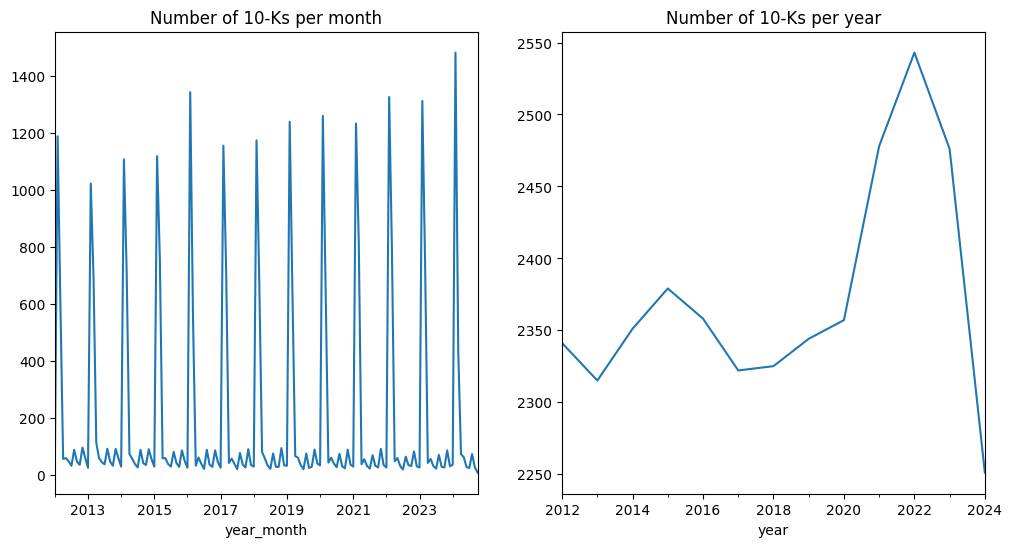

In [14]:
import sqlite3
import pandas as pd
import matplotlib.pylab as plt


conn = sqlite3.connect('/Users/ralfkellner/Documents/Python/Eikon/collect_data_returns_and_fundamentals/us_data.sqlite')
company_info = pd.read_sql("Select * From general_company_information;", conn)
conn.close()
company_info = company_info.rename({"TRBC Economic Sector Name": "Sector"}, axis = 1)

indices_to_drop = []
for ric, df_tmp in company_info.groupby("Instrument"):
    indices_to_drop.extend(list(df_tmp.replace("", pd.NA).isna().sum(axis = 1).argsort().index[1:]))
company_info.drop(indices_to_drop, axis = 0, inplace = True)
company_info = company_info[~company_info["CIK Number"].isna()]
company_info["CIK Number"] = company_info["CIK Number"].astype(int).apply(lambda x: str(x).zfill(10))
company_info.reset_index(drop = True, inplace = True)

conn = sqlite3.connect('/Users/ralfkellner/Documents/Python/Eikon/collect_data_returns_and_fundamentals/us_data.sqlite')
res = pd.read_sql("Select RIC, filingDate, ccv_cosine_sim From ccv_sim_tenks;", conn)
conn.close()

res = pd.merge(res, company_info.get(["Instrument", "Sector"]), left_on = "RIC", right_on = "Instrument", how = "left")
res.drop(["Instrument"], axis = 1, inplace = True)
res.loc[:, "year"] = pd.to_datetime(res['filingDate']).dt.to_period("Y")
res.loc[:, "year_month"] = pd.to_datetime(res['filingDate']).dt.to_period("M")

fig, axs = plt.subplots(1, 2, figsize = (12, 6))
res.get(["year_month", "ccv_cosine_sim"]).groupby("year_month").size().plot(ax = axs[0], title = "Number of 10-Ks per month")
res.get(["year", "ccv_cosine_sim"]).groupby("year").size().plot(ax = axs[1], title = "Number of 10-Ks per year")
plt.show()

To identify climate change related words, we follow the procedure of the original paper and determine all term frequencies of the 10-K term dictionary for the climate white papers. The frequencies are further multiplied with inverse-document frequencies from the 10-K corpus. This means high values for the climate change vocabulary appear for terms which can often be observed in climate white papers and rarely among all 10-K reports. The wordcloud below visualizes the top 150 terms where the size of each word is proportional to its term-frequency inverse-document frequency. Note that we include bigrams as well. 

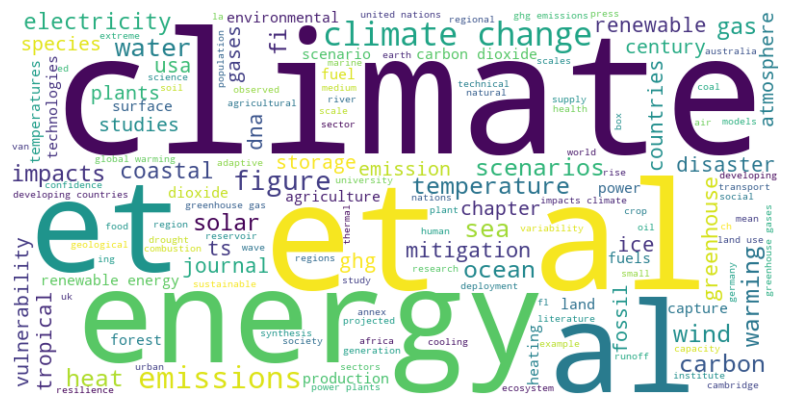

In [15]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt
import pandas as pd

term_frequencies = pd.read_csv("../notebooks/2024/climate_disclosure/climate_change_vocabulary_wordloud.csv").set_index("Unnamed: 0").to_dict()["0"]
wordcloud = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(term_frequencies)

plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')  # Remove axes
plt.show()

In order to identify how much an annual report (10-K) includes climate change specific language, we quantify the cosine similarity between the term-frequencey inverse-document-frequency vector of the climate change white papers with each corresponding 10-K vector. The boxplots below give us a detailed impression about the level of similarity which we refer to as "climate talk" over all reports, here, grouped by year. We observe a similar numerical range of climate talk for very year. In every year, a rather large amount of high outlier values can be observed. This may be due to differences of climate talk between companies or sectors of business operations. 

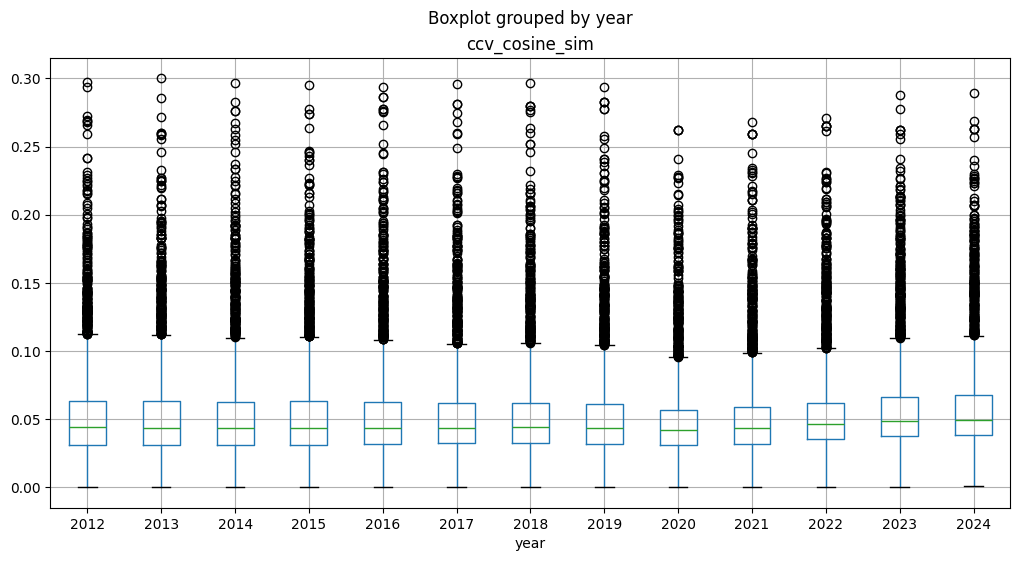

In [16]:
res.get(["year", "ccv_cosine_sim"]).boxplot(column = "ccv_cosine_sim", by = "year", figsize = (12, 6))
plt.show()

To explore this a little further, we take a look at climate talk over time by company sector. Hereby, significant differences can be observed between sectors. Climate talk in the energy and utitlites sector seems to be the most which makes sense as companies operating in these sectors face huge challenges which are related to climate transitions of their business models. Assuming, that climate talk as quantified here rather implies a higher level of climate change risks for companies, this information can be used to avoid certain companies in the portfolio of investors. 

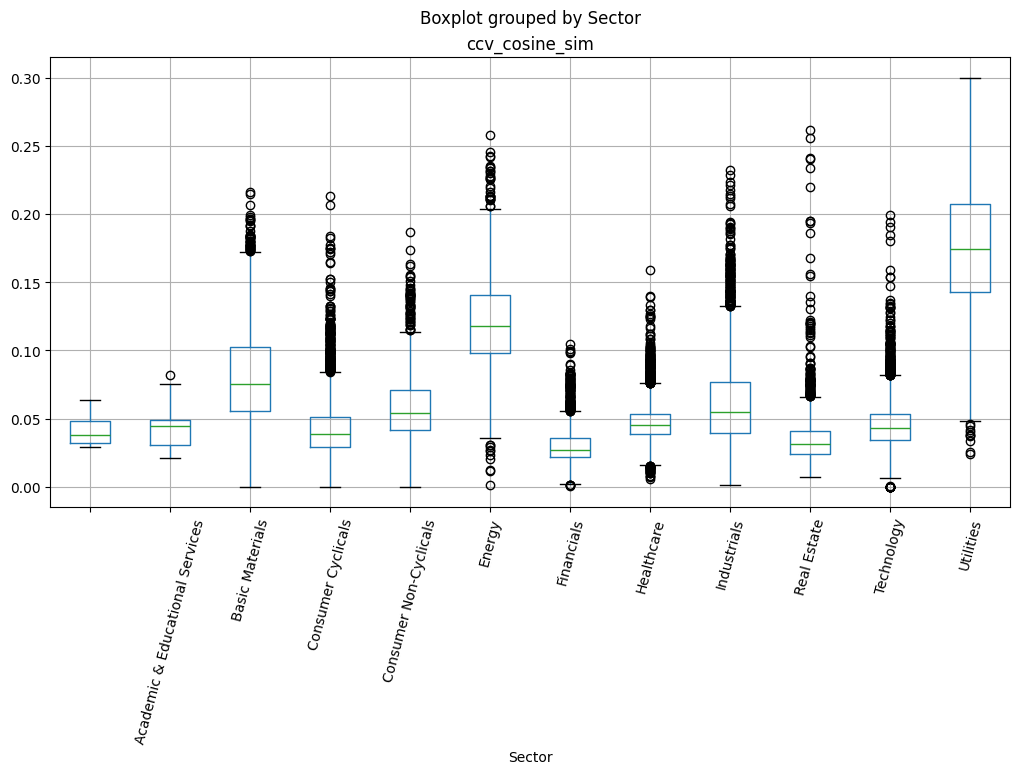

In [17]:
res.get(["Sector", "ccv_cosine_sim"]).boxplot(column = "ccv_cosine_sim", by = "Sector", figsize = (12, 6), rot = 75)
plt.show()